In [1]:
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from matplotlib import pyplot as plt

In [2]:
class ReadAE(nn.Module):
    def __init__(self, nSNP: int):
        super().__init__()
        latent_dim = int(np.ceil(nSNP/4))  # Size of embedding
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, (4,5), (4,1), (1, 2)),
            nn.PReLU(),
            nn.Conv2d(32, 64, (1,5), (1,1), 'same'),
            nn.PReLU(),
            nn.Conv2d(64, 128, (1,3), (1,1), 'same'),
            nn.PReLU(),
            nn.Flatten(),
            )
        
        self.fc1 = nn.Linear(128*nSNP, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 128*nSNP)
        self.act1 = nn.PReLU()

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, (1,3), (1,1), (0, 1)),
            nn.PReLU(),
            nn.ConvTranspose2d(64, 32, (1,5), (1,1), (0, 2)),
            nn.PReLU(),
            nn.ConvTranspose2d(32, 1, (4,5), (4,1), (0,2)),
            # nn.PReLU()
            )

    def forward(self, x):
        x_code = self.encoder(x)
        x_fc1 = self.fc1(x_code)
        x_flatten = self.act1(self.fc2(x_fc1))
        x_reshape = x_flatten.view(-1, 128, 1, nSNP)
        return x_fc1, self.decoder(x_reshape)


In [3]:
nSNP = 589
x = torch.randn(5, 1, 4, nSNP)
conv1 = nn.Conv2d(1, 32, (4,5), (4,1), (1, 2))
conv1(x).shape

x = torch.randn(23, 75392)
fc = nn.Linear(128*nSNP, int(np.ceil(nSNP/4)))
fc(x).shape

torch.Size([23, 148])

In [4]:
class SNVMatrixDataset(Dataset):
    def __init__(self, SNV_file, transform=None):
        """
        SNV_file: txt file containing SNV matrix
        """
        
        self.SNV_matrix = np.loadtxt(SNV_file, dtype=int)
    
    def __len__(self):
        return np.shape(self.SNV_matrix)[0]
    
    def __getitem__(self, idx):
        SNV_row = torch.from_numpy(self.SNV_matrix[idx])
        SNV_row_onehot = F.one_hot(SNV_row)[:,1:]
        SNV_row_onehot = SNV_row_onehot.type(torch.float32)
        SNV_row_onehot = SNV_row_onehot.transpose(1,0)
        return SNV_row_onehot[None,:]

In [29]:
SNVdata = SNVMatrixDataset('Simulated_data/K3/cov15/sample4/simu_erro1_K3_cov15'\
                           '_l5000_iter_7_SNV_matrix.txt')
nSNP = SNVdata[0].shape[2] # Number of SNVs
num_epoch = 100
num_read = len(SNVdata)  # Number of reads
batch_size = int(np.ceil(num_read/20))

In [30]:
dataloader = DataLoader(SNVdata, batch_size=batch_size,
                        shuffle=True, num_workers=0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #  use gpu if available

embedAE = ReadAE(nSNP).to(device)  # Create and send model to device

optimizer = optim.Adam(embedAE.parameters(), lr=1e-2)
MSE = nn.MSELoss()
train_loss_arr = []

for epoch in range(num_epoch):
    loss = 0
    for batch_data in dataloader:
        optimizer.zero_grad()  # reset the gradients back to zero
        _, recon = embedAE(batch_data) # compute reconstructions
        train_loss = MSE(recon, batch_data)  # compute training reconstruction loss
        train_loss.backward()  # compute accumulated gradients
        optimizer.step()
        loss += train_loss.item()  # add the mini-batch training loss to epoch loss
    loss = loss / len(dataloader)  # compute the epoch training loss
    train_loss_arr.append(loss)

    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.2f}".format(epoch + 1, num_epoch, loss))

epoch : 1/100, loss = 3955.41
epoch : 2/100, loss = 218.17
epoch : 3/100, loss = 6.73
epoch : 4/100, loss = 0.79
epoch : 5/100, loss = 0.45
epoch : 6/100, loss = 0.33
epoch : 7/100, loss = 0.28
epoch : 8/100, loss = 0.25
epoch : 9/100, loss = 0.22
epoch : 10/100, loss = 0.20
epoch : 11/100, loss = 0.18
epoch : 12/100, loss = 0.16
epoch : 13/100, loss = 0.15
epoch : 14/100, loss = 0.14
epoch : 15/100, loss = 0.13
epoch : 16/100, loss = 0.12
epoch : 17/100, loss = 0.11
epoch : 18/100, loss = 0.11
epoch : 19/100, loss = 0.10
epoch : 20/100, loss = 0.09
epoch : 21/100, loss = 0.09
epoch : 22/100, loss = 0.08
epoch : 23/100, loss = 0.08
epoch : 24/100, loss = 0.08
epoch : 25/100, loss = 0.07
epoch : 26/100, loss = 0.07
epoch : 27/100, loss = 0.07
epoch : 28/100, loss = 0.07
epoch : 29/100, loss = 0.06
epoch : 30/100, loss = 0.06
epoch : 31/100, loss = 0.06
epoch : 32/100, loss = 0.06
epoch : 33/100, loss = 0.06
epoch : 34/100, loss = 0.05
epoch : 35/100, loss = 0.05
epoch : 36/100, loss = 0

In [24]:
for name, param in embedAE.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)

encoder.0.weight torch.Size([32, 1, 4, 5])
encoder.0.bias torch.Size([32])
encoder.1.weight torch.Size([1])
encoder.2.weight torch.Size([64, 32, 1, 5])
encoder.2.bias torch.Size([64])
encoder.3.weight torch.Size([1])
encoder.4.weight torch.Size([128, 64, 1, 3])
encoder.4.bias torch.Size([128])
encoder.5.weight torch.Size([1])
fc1.weight torch.Size([136, 69376])
fc1.bias torch.Size([136])
fc2.weight torch.Size([69376, 136])
fc2.bias torch.Size([69376])
act1.weight torch.Size([1])
decoder.0.weight torch.Size([128, 64, 1, 3])
decoder.0.bias torch.Size([64])
decoder.1.weight torch.Size([1])
decoder.2.weight torch.Size([64, 32, 1, 5])
decoder.2.bias torch.Size([32])
decoder.3.weight torch.Size([1])
decoder.4.weight torch.Size([32, 1, 4, 5])
decoder.4.bias torch.Size([1])


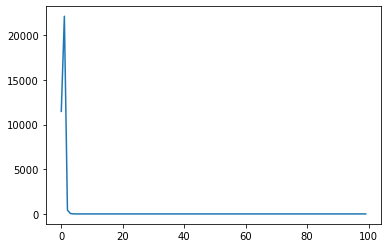

In [21]:
plt.plot(train_loss_arr)